In [1]:
# Reproducibility
seed = 125

# Architecture
input_shape = (256, 256, 1)
kernel_shape = (3, 3)
pool_size = (2, 2)

# Training
fake_path = "./data/AI recognition dataset/fakeV2/fake-v2"
path_real = "./data/AI recognition dataset/real"
initial_learning_rate = 0.001
batch_size = 32
sample_frac = 500
epochs = 50
patience = 10
decay_after_n_epochs = 10
decay_rate = 0.5
verbose = 1
l2_regularization = 0.001
params = {
    "epochs": epochs,
    "batch_size": batch_size,
    "patience": patience,
    "seed": seed,
    "verbose": verbose,
    "sample_frac": sample_frac,
    "l2_regularization": l2_regularization
}

model_id = f"model_v{params['epochs']}_bs{params['batch_size']}_pat{params['patience']}_frac_{sample_frac}"
checkpoint_path = f"./checkpoints/{model_id}.keras"

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, Model
import keras.backend as K
import keras

import tensorflow as tf
from preprocessing.patch_generator import preprocess
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")
else:
    print("No GPUs available.")

No GPUs available.


In [5]:
print(tf.__version__)

2.19.0


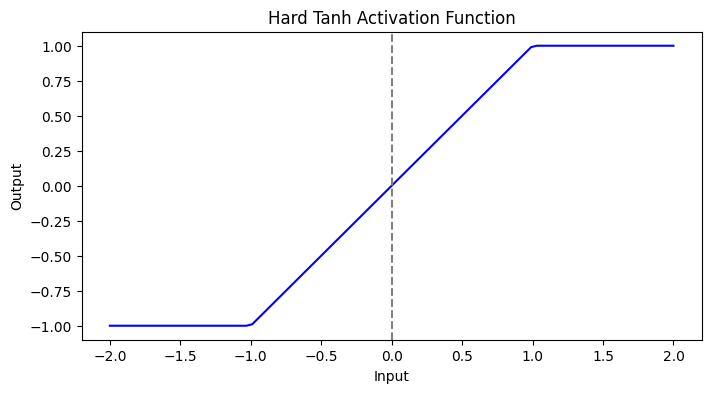

In [6]:
@tf.function
def hard_tanh(x) -> tf.Tensor:
    return tf.maximum(tf.minimum(x, 1), -1)

x_values = np.linspace(-2, 2, 100)
y_values = hard_tanh(tf.convert_to_tensor(x_values)).numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_values, y_values, color="blue")
plt.title("Hard Tanh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

In [8]:
def load_images(
    path: str,
    label: int,
    sample_frac: Union[int, float]) -> Tuple[List[str], List[int]]:
    imgs = [os.path.join(path, img) for img in os.listdir(path)]

    if isinstance(sample_frac, int) and sample_frac > 1:
        sample_count = min(sample_frac, len(imgs))
    else:
        sample_count = int(len(imgs) * sample_frac)

    sampled_imgs = imgs[:sample_count]
    labels = [label for _ in range(len(sampled_imgs))]
    return sampled_imgs, labels

ai_imgs, ai_label = load_images(fake_path, 1, sample_frac)
real_imgs, real_label = load_images(path_real, 0, sample_frac)

In [9]:
X = ai_imgs + real_imgs
y = ai_label + real_label

X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

def dict_map(X1, X2, y):
    return {"rich_texture": X1, "poor_texture": X2}, y

def set_shapes(frt, fpt, label=None):
    frt.set_shape(input_shape)
    fpt.set_shape(input_shape)
    if label is not None:
        label.set_shape([])
        return frt, fpt, label
    else:
        return frt, fpt

dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train), seed)
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_set = (
    tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(10)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
from collections import Counter
Counter(y_validate)

Counter({1: 150, 0: 150})

In [11]:
REG_PARAMS = {"kernel_regularizer": keras.regularizers.l2(l2_regularization)}

class FeatureExtractionLayer(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", **REG_PARAMS)
        self.bn = layers.BatchNormalization()
        self.activation = layers.Lambda(hard_tanh)

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.activation(x)
        return x

input0 = layers.Input(shape=input_shape, name="rich_texture")
input1 = layers.Input(shape=input_shape, name="poor_texture")

l0 = FeatureExtractionLayer(name="feature_extraction_layer_rich_texture")(input0)
l1 = FeatureExtractionLayer(name="feature_extraction_layer_poor_texture")(input1)

contrast = layers.subtract((l0, l1))

x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(contrast)
x = layers.BatchNormalization()(x)
for i in range(3):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.BatchNormalization()(x)

for i in range(4):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation="sigmoid", **REG_PARAMS)(x)

model = Model(
    inputs=(input0, input1), outputs=x, name="rt_pt_contrast"
)

steps_per_epoch  = int(len(X_train) / batch_size)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch * decay_after_n_epochs,
    decay_rate=decay_rate
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()

Model: "rt_pt_contrast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rich_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ poor_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ rich_texture[0][… │
│ (FeatureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ poor_texture[0][… │
│ (FeatureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 254, 254,  │          0 │ feature_extracti… │
│                     │ 32)               │            │ feature_extracti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 252, 252,  │      9,248 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 252, 252,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 250, 250,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 250,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 248, 248,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 248,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 246, 246,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ batch_normalizat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 244, 244,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 244, 244,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 242, 242,  │      9,248 │ batch_normalizat

 Total params: 113,569 (443.63 KB)

 Trainable params: 112,609 (439.88 KB)

 Non-trainable params: 960 (3.75 KB)

## Making data pipeline

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path, monitor="val_loss", save_best_only=True, verbose=verbose
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=patience, verbose=verbose, restore_best_weights=True
)

## Training the model

In [13]:
history = model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    validation_data=validation_set,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - binary_accuracy: 0.7725 - loss: 0.8379 - precision: 0.7683 - recall: 0.8156 
Epoch 1: val_loss improved from inf to 1.08429, saving model to ./checkpoints/model_v50_bs32_pat10_frac_500.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 406s 19s/step - binary_accuracy: 0.7745 - loss: 0.8366 - precision: 0.7690 - recall: 0.8178 - val_binary_accuracy: 0.5000 - val_loss: 1.0843 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - binary_accuracy: 0.9286 - loss: 0.6991 - precision: 0.9444 - recall: 0.9444

c:\Users\yveem\anaconda3\envs\detection\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.08429 to 1.08369, saving model to ./checkpoints/model_v50_bs32_pat10_frac_500.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - binary_accuracy: 0.9286 - loss: 0.6991 - precision: 0.9444 - recall: 0.9444 - val_binary_accuracy: 0.5000 - val_loss: 1.0837 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - binary_accuracy: 0.8955 - loss: 0.6907 - precision: 0.8633 - recall: 0.9351 
Epoch 3: val_loss did not improve from 1.08369
21/21 ━━━━━━━━━━━━━━━━━━━━ 390s 19s/step - binary_accuracy: 0.8961 - loss: 0.6898 - precision: 0.8645 - recall: 0.9351 - val_binary_accuracy: 0.5133 - val_loss: 1.1213 - val_precision: 0.5068 - val_recall: 1.0000
Epoch 4/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3:01 9s/step - binary_accuracy: 0.8571 - loss: 0.7241 - precision: 0.7692 - recall: 0.9091
Epoch 4: val_loss did not improve from 1.08369
21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - binary_accuracy: 0.8571 - loss: 0.7241 - precision: 0.7692 - rec

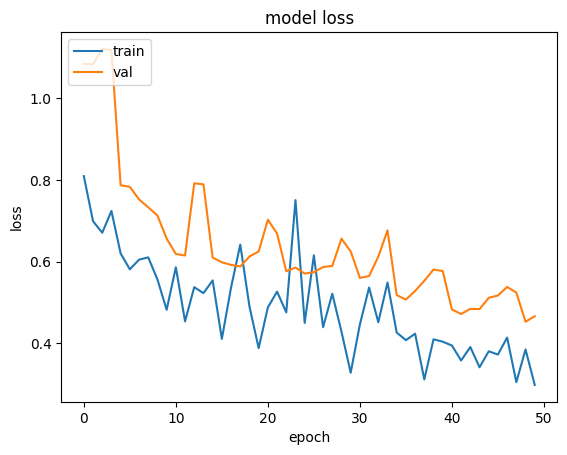

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [15]:
history.history

{'binary_accuracy': [0.8154761791229248,
  0.9285714030265808,
  0.9092261791229248,
  0.8571428656578064,
  0.9241071343421936,
  0.8928571343421936,
  0.9166666865348816,
  0.9285714030265808,
  0.9360119104385376,
  0.9642857313156128,
  0.925595223903656,
  0.9642857313156128,
  0.9434523582458496,
  0.9285714030265808,
  0.925595223903656,
  0.9642857313156128,
  0.9270833134651184,
  0.9285714030265808,
  0.9523809552192688,
  1.0,
  0.9523809552192688,
  0.9285714030265808,
  0.9523809552192688,
  0.8928571343421936,
  0.9583333134651184,
  0.8214285969734192,
  0.9538690447807312,
  0.9285714030265808,
  0.9642857313156128,
  1.0,
  0.949404776096344,
  0.9285714030265808,
  0.9523809552192688,
  0.9285714030265808,
  0.961309552192688,
  0.9285714030265808,
  0.949404776096344,
  1.0,
  0.9717261791229248,
  0.9642857313156128,
  0.96875,
  0.9642857313156128,
  0.96875,
  1.0,
  0.9672619104385376,
  0.9642857313156128,
  0.9553571343421936,
  1.0,
  0.9717261791229248,
  1.0

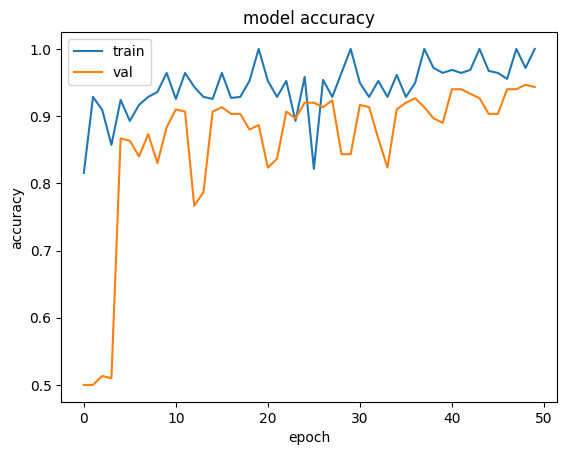

In [16]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [17]:
def save_model(model_id: str, model: Model, params: dict):
    model_path = f"./models/{model_id}.keras"
    model.save(model_path)
    params["history"] = history.history
    with open(f"./models/{model_id}.json", "w") as f:
        json.dump(params, f, indent=4)
    
    return model_path

In [18]:
model_path = save_model(model_id, model, params)

In [22]:
from tensorflow.keras import models

def inference(model_path, images_path):
    custom_objects = {
        'FeatureExtractionLayer': FeatureExtractionLayer,
        'hard_tanh': hard_tanh
    }
    model = models.load_model(model_path, custom_objects=custom_objects)

    image_paths = [os.path.join(images_path, fname) for fname in os.listdir(images_path)][:5]
    dummy_labels = [0] * len(image_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, dummy_labels))

    dataset = dataset.map(
        lambda path, label: tf.py_function(
            preprocess, [path, label], [tf.float64, tf.float64, tf.int32]
        )
    )

    dataset = dataset.map(set_shapes)
    dataset = dataset.map(lambda frt, fpt, label: {'rich_texture': frt, 'poor_texture': fpt})
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    predictions = model.predict(dataset, batch_size=batch_size)

    return predictions

In [24]:
preds = inference(model_path, "./data/AI recognition dataset/fakeV2/fake-v2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [25]:
preds

array([[0.9501062 ],
       [0.90735847],
       [0.9809298 ],
       [0.9759759 ],
       [0.9870185 ]], dtype=float32)

In [26]:
preds_real = inference(model_path, "./data/AI recognition dataset/real")
preds_real

c:\Users\yveem\anaconda3\envs\detection\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'feature_extraction_layer_rich_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\yveem\anaconda3\envs\detection\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'feature_extraction_layer_poor_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.00274754],
       [0.72200346],
       [0.8098036 ],
       [0.85625684],
       [0.9681962 ]], dtype=float32)